In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [2]:
train = pd.read_csv('C:/Users/iyuo1/OneDrive/Documents/P-SAT/주제분석 패키지/주제분석 3주차 패키지/train.csv')
test = pd.read_csv('C:/Users/iyuo1/OneDrive/Documents/P-SAT/주제분석 패키지/주제분석 3주차 패키지/test.csv')


train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

In [3]:
# 1.1 모델 불러오기
import pickle
import joblib

best_lgbm_reg.booster_.save_model('mode.txt')
bst = lgb.Booster(model_file='mode.txt')

joblib.dump(best_lgbm_reg, 'lgb.pkl') #save
gbm_pickle = joblib.load('lgb.pkl') #load

In [4]:
# 1.2 Feature Importance 확인과 해석
from lightgbm import plot_importance, LGBMClassifier

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

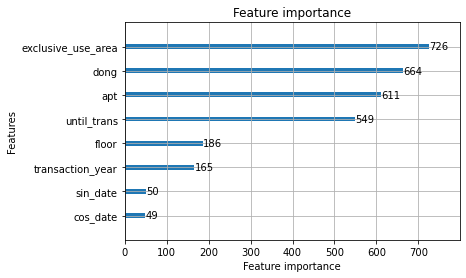

In [5]:
plot_importance(best_lgbm_reg)

Feature Importance를 통해, 각 변수들이 가지에서 몇 번 등장하는지, 혹은 불순도를
낮추는 지를 알 수 있다. 즉, 각 특성들이 모델 예측 결과에 얼마나 큰 영향을 미쳤는지,
해당 특성의 중요도를 평가할 수 있다. 이 모델에서는 exclusive_use_area와 dong, apt의
특성이 예측 결과에 중요한 영향을 미쳤음을 알 수 있다. 
Feature Importance를 통해 데이터와 모델의 구조를 직관적으로 파악할 수 있고,
중요한 특징만 골라내어 더 효율적인 모델을 구축할 수 있다.
하지만 -영향(negative)을 주는 feature를 알 수 없다는 문제점이 있다.

In [6]:
# 1.3 Randomness Control
import random
import os
np.random.seed(42)
os.urandom(42)

b'\xb7b\x9c\x0e\xe9\x80b\xccT\xe5\x9cy\xeb9\xf1L\\5n\x87P\xfeY\xaaK\xb4CgQ\xf7\xf1\xb6\x9c\x1c\xf4\xa4\x92l[\xb2\x93\x0c'

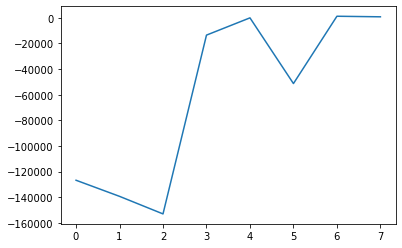

In [7]:
# 1.4 Permutation Feature Importance
from sklearn.inspection import permutation_importance
perm = permutation_importance(best_lgbm_reg, test_cbe, test_y, random_state=42)
plt.plot(perm.importances_mean)

In [8]:
# 1.5 SHAP(SHapley Additive exPlanations)의 확인과 해석
! pip install shap

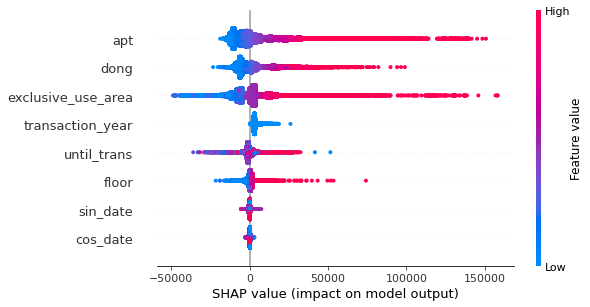

In [9]:
import shap
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(test_cbe)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0)).sort_values(ascending=False)
shap.summary_plot(shap_values, test_cbe)

더 적은 apt,dong,exclusive_use_area는 아파트 가격을 하락시키고, 더 많은 apt,dong,
exclusive_use_area는 아파트 가격을 상승시킨다. 

In [10]:
# 2,1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.
train = pd.read_csv('C:/Users/iyuo1/OneDrive/Documents/P-SAT/주제분석 패키지/주제분석 3주차 패키지/train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [11]:
pip install tensorflow

In [12]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [13]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

모델에 4종류의 층을 만들었다. 처음에는 train_tune_cbe.key 차원인 2D 텐서를 입력받았다.
그 후에는 input에 대한 제한 없이 층을 만들었다. keras에서는 모델에 추가된 층을 자동으로
상위 층의 크기에 맞추어주기 때문에 위와 같이 작성하면 두 번째 층은 첫 번째 층의 출력 크기를
입력 크기로 자동 채택하게 된다. 
학습 과정을 조절하는 열쇠로 optimizer를 사용했는데 손실 함수를 기반으로 네트워크 업데이트를 결정한다.
특정 종류의 SGD(확률적 경사 하강법)을 구현한다는데, 0.0001 만큼을 구현하는 듯 하다.

순차모델 Sequential은 층을 더해주는 모델이다.
Dense로 만들어진 노드를 순차모델 Sequential에 더하면 모델 안에 있는 다른 노드들과 연결된다.
첫 번째 층의경우, 입력값 8에 바이어스 노드(1)=9개의 인풋 노드가 있고 파라미터는 9x256=2304이다.

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 2.2 training loss와 validation loss를 시각화하세요.
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

Epoch 1/300
611/611 [==============================] - 4s 6ms/step - loss: 1191481399.3203 - mse: 1191481399.3203 - val_loss: 355727200.0000 - val_mse: 355727200.0000
Epoch 2/300
611/611 [==============================] - 2s 3ms/step - loss: 228660853.8039 - mse: 228660853.8039 - val_loss: 338325504.0000 - val_mse: 338325504.0000
Epoch 3/300
611/611 [==============================] - 2s 3ms/step - loss: 237237261.4641 - mse: 237237261.4641 - val_loss: 341168256.0000 - val_mse: 341168256.0000
Epoch 4/300
611/611 [==============================] - 2s 3ms/step - loss: 231953833.3072 - mse: 231953833.3072 - val_loss: 320458048.0000 - val_mse: 320458048.0000
Epoch 5/300
611/611 [==============================] - 2s 3ms/step - loss: 235333711.5033 - mse: 235333711.5033 - val_loss: 328142112.0000 - val_mse: 328142112.0000
Epoch 6/300
611/611 [==============================] - 2s 3ms/step - loss: 235274381.0980 - mse: 235274381.0980 - val_loss: 315083072.0000 - val_mse: 315083072.0000
Epoch 7/

In [17]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [18]:
# 2.3 어떤 문제가 발생했는지 설명해주세요.
print(history.history['loss'])
print(history.history['mse'])
print(history.history['val_loss'])
print(history.history['val_mse'])

[552407488.0, 233167232.0, 232491264.0, 232050976.0, 231942432.0, 231643392.0, 231438928.0, 231111536.0, 230862832.0, 230521024.0, 230155072.0, 229881680.0, 229487872.0, 229114880.0, 228573520.0, 228208368.0, 227694704.0, 227136864.0, 226365680.0, 225839648.0, 224935632.0, 224079232.0, 222978064.0, 222022016.0, 220858288.0, 219558288.0, 218163616.0, 216764480.0, 215049808.0, 213338400.0, 211655616.0, 209876160.0, 208307696.0, 206755424.0, 205362992.0, 204048560.0, 202999904.0, 201992736.0, 201013360.0, 199964224.0, 199442304.0, 198741392.0, 198258048.0, 197721104.0, 197364752.0, 196980560.0, 196378288.0, 195844000.0, 195728176.0, 195434944.0, 194944416.0, 194525936.0, 193996816.0, 193981056.0, 193476608.0, 193303104.0, 192870032.0, 192494592.0, 192260592.0, 192164224.0, 191565600.0, 191476624.0, 191387712.0, 190830816.0, 190735296.0, 190598160.0, 190047600.0, 189636560.0, 189641472.0, 188906224.0, 188713248.0, 188272416.0, 188036176.0, 187694096.0, 187335888.0, 187033680.0, 186724048.0

loss의 시각화를 통해 한눈에 파악해보자.

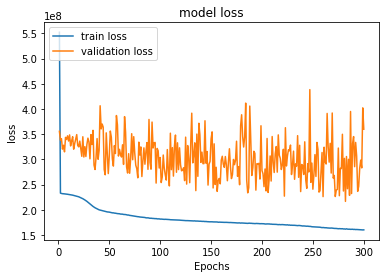

In [19]:
epochs=range(1,301)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.show()

위의 loss 그래프를 보면 알 수 있다시피, validation loss에서 큰 fluctuation이 일어났다.
큰 fluctuation에는 dense 조절, batch_size 조절, regularization, dropout, batch normalization 등의 방법을 활용해
더 나은 validation loss를 얻도록 해야한다.
mse를 비교해 보았을때도  1.2∗10^8보다 수가 커졌기에 training loss는 감소하지만
validaion loss는 증가하는 구간이 생겨 overfitting이 발생했다.

In [20]:
# 2.4 더 좋은 성능의 딥러닝 모델을 위해
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

딥러닝 모델의 학습에는 시간이 많이 소요되므로 학습을 위한 epoch를 작게 해 
1회 validation에 걸리는 시간을 단축하는것이 효과적이라고 한다.
그리고 batch size는 2배로 키워보았다.

In [21]:
history = model.fit(test_cbe,test_y, epochs=100, validation_data = (train_cbe,train_y), batch_size = 400)

Epoch 1/100
229/229 [==============================] - 3s 11ms/step - loss: 81974160.0000 - mse: 81974160.0000 - val_loss: 3217895936.0000 - val_mse: 3217895936.0000
Epoch 2/100
229/229 [==============================] - 3s 11ms/step - loss: 15211551.0000 - mse: 15211551.0000 - val_loss: 3005330688.0000 - val_mse: 3005330688.0000
Epoch 3/100
229/229 [==============================] - 2s 10ms/step - loss: 11408888.0000 - mse: 11408888.0000 - val_loss: 3199770368.0000 - val_mse: 3199770368.0000
Epoch 4/100
229/229 [==============================] - 2s 10ms/step - loss: 8565530.0000 - mse: 8565530.0000 - val_loss: 3122350080.0000 - val_mse: 3122350080.0000
Epoch 5/100
229/229 [==============================] - 2s 10ms/step - loss: 6729241.0000 - mse: 6729241.0000 - val_loss: 3134508800.0000 - val_mse: 3134508800.0000
Epoch 6/100
229/229 [==============================] - 2s 10ms/step - loss: 5485935.0000 - mse: 5485935.0000 - val_loss: 3357342464.0000 - val_mse: 3357342464.0000
Epoch 7/10